# Place Cell Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exdir
import exdir.plugins.quantities
import exdir.plugins.git_lfs
import seaborn as sns
import os
import expipe
import pathlib
import numpy as np
import place_stimulation as ps
import neo
import quantities as pq
import matplotlib.pylab as plt

par = {'speed_filter': 0.3, # m/s
       'pos_fs': 60 ,
       'f_cut': 1,
       'spat_binsize': 0.02 ,
       'spat_smoothing': 0.025,
       'grid_stepsize': 0.1 ,
       'box_xlen': 1 ,
       'box_ylen': 1 ,
       'spike_size': 10,
       'field_max_wall_extent':0.1,
       'field_min_bins':12
}

In [ ]:
# functions
def cart2pol(x, y):
    """ 
    converting cartesian coordinates 
    into polar coordinates
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

## Load project in python using expipe

In [3]:
project_path = r'C:\Users\dejanam\data\test_pcstim'
project = expipe.get_project(project_path)
actions = project.actions
actions

In [4]:
action = project.actions['1849-260219-2']
data_path = ps.get_data_path(action)

C:\Users\dejanam\data\test_pcstim
actions\1849-260219-2\data\main.exdir


In [5]:
sptr = ps.load_spiketrains(data_path, channel_idx=7, remove_label='noise')
st = sptr[1]

## Plots
### Waveforms

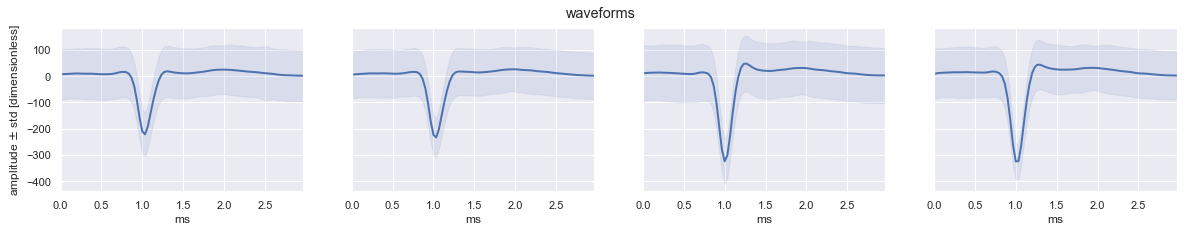

In [42]:
# Source: Mikkel
def plot_waveforms(sptr, color='b', fig=None, title='waveforms', lw=2, gs=None):
    """
    Visualize waveforms on respective channels
    Parameters
    ----------
    sptr : neo.SpikeTrain
    color : color of waveforms
    title : figure title
    fig : matplotlib figure
    Returns
    -------
    out : fig
    """
    import matplotlib.gridspec as gridspec
    nrc = sptr.waveforms.shape[1]
    if fig is None:
        fig = plt.figure(figsize=(20, 3))
        sns.set(color_codes=True, style="darkgrid")
    axs = []
    ax = None
    for c in range(nrc):
        if gs is None:
            ax = fig.add_subplot(1, nrc, c+1, sharex=ax, sharey=ax)
        else:
            gs0 = gridspec.GridSpecFromSubplotSpec(1, nrc, subplot_spec=gs)
            ax = fig.add_subplot(gs0[:, c], sharex=ax, sharey=ax)
        axs.append(ax)
    for c in range(nrc):
        wf = sptr.waveforms[:, c, :]
        m = np.mean(wf, axis=0)
        stime = np.arange(m.size, dtype=np.float32)/sptr.sampling_rate
        stime.units = 'ms'
        sd = np.std(wf, axis=0)
        axs[c].plot(stime, m, color=color, lw=lw)
        axs[c].fill_between(stime, m-sd, m+sd, alpha=.1, color=color)
        if sptr.left_sweep is not None:
            sptr.left_sweep.units = 'ms'
            axs[c].axvspan(sptr.left_sweep, sptr.left_sweep, color='k',
                           ls='--')
        axs[c].set_xlabel(stime.dimensionality)
        axs[c].set_xlim([stime.min(), stime.max()])
        if c > 0:
            plt.setp(axs[c].get_yticklabels(), visible=False)
    axs[0].set_ylabel(r'amplitude $\pm$ std [%s]' % wf.dimensionality)
    fig.suptitle(title)
    return fig
wf_plot = plot_waveforms(st)

In [7]:
#plt.plot(st.waveforms[::100, 0, :].T, color='k', lw=0.1)
#plt.plot(np.mean(st.waveforms[:, 0, :], axis=0), lw=2)

### Path

In [38]:
x, y, t, speed = ps.load_tracking(data_path, par, select_tracking=1)


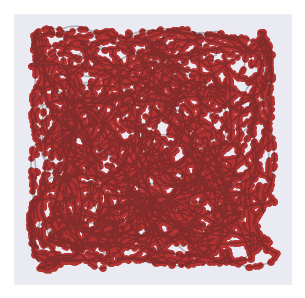

In [9]:
ps.plot_path(x, y, t, st)

In [10]:
#ps.plot_path(x, y, t, st, scatter=False)

def plot_split_path(x, y, t, sptr, figsize=[5, 5], ax1=None, ax2=None, s=30, c=[0.7, 0.2, 0.2], scatter=True):
    if ax1 and ax2 is None:
        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(111)
        ax2 = fig.add_subplot(112)
    origin = [x[0], y[0]]
    x_axis = np.array(x - origin[0])
    y_axis = np.array(y - origin[1])
    new_x = np.insert(x_axis, 0, origin[0])
    new_y = np.insert(y_axis, 0, origin[1])
    
    ax1.plot(new_x, t, 'k', alpha=0.3)
    ax2.plot(new_y, t, 'k', alpha=0.3)

    sptr_t = sptr[sptr.times.magnitude < np.max(t)]
    sptr_t = sptr_t[sptr_t.times.magnitude > np.min(t)]

    x_spike = interp1d(t, new_x)(sptr_t)
    y_spike = interp1d(t, new_y)(sptr_t)

    if scatter:
        ax1.scatter(x_spike, t, s=s, c=c)
        ax2.scatter(y_spike, t, s=s, c=c, edgecolor="b")
        plt.xticks([])
        plt.yticks([])
    else:
        plt.xticks([])
        plt.yticks([])

    return fig

In [61]:
def plot_split_path(sptr, data_path, par, fig=None, scatter=False):
    from scipy.interpolate import interp1d
    if fig is None:
        fig = plt.figure()
        # sns.set(color_codes=True, style="darkgrid")

    # making subplots
    nr_channel = 4
    axs = []
    for channel in range(nr_channel):
        ax = plt.subplot2grid((2, 4), (0, channel), rowspan=2, fig=fig)
        axs.append(ax)
    
    # saving spiketrains from all four tetrodes in channel group
    for channel in range(nr_channel):
        x, y, t, speed = ps.load_tracking(data_path, par, select_tracking=1)
        sptr_c = sptr[channel][sptr[channel].times.magnitude < np.max(t)]
        sptr_c = sptr_c[sptr_c.times.magnitude > np.min(t)]
        
        r = np.sqrt(x ** 2 + y ** 2)
        axs[channel].plot(r, t, 'k', alpha=0.3)

        #x_spike = interp1d(t, x)(sptr_c)
        #y_spike = interp1d(t, y)(sptr_c)
        #r_spike = np.sqrt(x_spike ** 2 + y_spike ** 2)
        #if scatter:
        #    axs[channel].scatter(r_spike, t, edgecolor="b")
        #    plt.xticks([])
        #    plt.yticks([])
        #else:
        #    plt.xticks([])
        #    plt.yticks([])

    return fig

IndexError: list index out of range

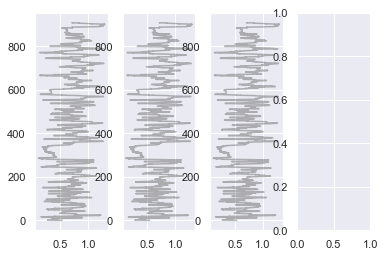

In [62]:
plot_split_path(sptr, data_path, par)

In [63]:
%debug

> <ipython-input-61-2d66eea3af9e>(17)plot_split_path()
     15     for channel in range(nr_channel):
     16         x, y, t, speed = ps.load_tracking(data_path, par, select_tracking=1)
---> 17         sptr_c = sptr[channel][sptr[channel].times.magnitude < np.max(t)]
     18         sptr_c = sptr_c[sptr_c.times.magnitude > np.min(t)]
     19 

ipdb> channel
3
ipdb> len(sptr)
3
ipdb> exit


### Fire-rate map

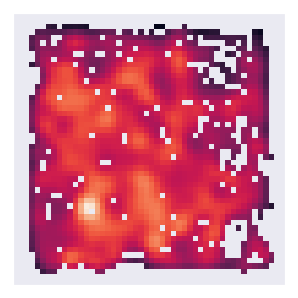

In [41]:
ps.plot_rate_map(x, y, t, st)

### All plots together (saved)

In [ ]:
ax1 = plt.subplot2grid((4, 4), (2, 0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((4, 4), (1, 0), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((4, 4), (1, 2), rowspan=2, colspan=2)